#본 코드는 VGG-16을 Rank-1으로 구현한 것으로 VGG-16의 모델은 밑의 파일을 기반으로 작성함.


https://github.com/petrasuk/tiny_imagenet/blob/master/src/vgg_16.py

Cifar10 예제는 다음을 참조함.
http://solarisailab.com/archives/2325

# Normal CNN 

cifar 10 data set에 대해서 함.

## 나중에 다시 고쳐보기

# assume input_op shape is 224x224x3 

 
# block 1 -- outputs 112x112x64 

convolution 2번 후에 max pooling

 
# block 2 -- outputs 56x56x128 
convolution 2번 후에 max pooling

 
# block 3 -- outputs 28x28x256 
convolution 2번 후에 max pooling
 
# block 4 -- outputs 14x14x512 
convolution 3번 후에 max pooling


# block 5 -- outputs 7x7x512 
convolution 3번 후에 max pooling

# flatten 1
flatten 후 --> 4096


# flatten 2
flatten 후 --> 2048

 
# fully connected 
fc6 = fc_op(resh1, name="fc6", n_out=1024) 
fc6_drop = tf.nn.dropout(fc6, dropout_keep_prob, name="fc6_drop") 
fc7 = fc_op(fc6_drop, name="fc7", n_out=1024) 
fc7_drop = tf.nn.dropout(fc7, dropout_keep_prob, name="fc7_drop") 
fc8 = fc_op(fc7_drop, name="fc8", n_out=10) 
   
softmax = tf.nn.softmax(fc8) 
predictions = tf.argmax(softmax, 1) 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import re
import os

# use matplotlib as inline
%matplotlib inline 
from functools import partial
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.python.keras._impl.keras.datasets.cifar10 import load_data

# 다음 배치를 읽어오기 위한 next_batch 유틸리티 함수를 정의합니다. 
def next_batch(num, data, labels): 
    ''' 
    Return a total of `num` random samples and labels.  
    ''' 
    idx = np.arange(0 , len(data)) 
    np.random.shuffle(idx) 
    idx = idx[:num] 
    data_shuffle = [data[i] for i in idx] 
    labels_shuffle = [labels[i] for i in idx] 

 
    return np.asarray(data_shuffle), np.asarray(labels_shuffle) 

In [3]:
 #GPU를 90%까지 쓸 수 있기 위해 설정함.  
config = tf.ConfigProto()
config.gpu_options.allocator_type ='BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.80

In [4]:
x = tf.placeholder("float", [None, 32, 32, 3])
#x2 = tf.image.resize_images(x, [224, 224])
phase = tf.placeholder(tf.bool, name='phase') #batch normalization을 training모드인지 test모드인지

# conv1_1
input_num = 3
dim = 3 # 1-rank 1D filter의 한쪽 사이즈
num = 8 # 1-rank 1D filter의 갯수. 8개이면 2개의 1D filter에 의해 2D filter는 64개가 된다.
output_num = num*num

#W1_1 = tf.Variable(tf.random_uniform([3,3,input_num,output_num], -0.5, 0.5))
#W1_1 = tf.Variable(tf.random_uniform([3,3,input_num,output_num], -0.5, 0.5))
W1_1 = tf.get_variable("W", shape=[3,3,input_num,output_num],
           initializer=tf.contrib.layers.xavier_initializer())


L1 = tf.nn.conv2d(x, W1_1, strides=[1, 1, 1, 1], padding='SAME')

Bias1_1 = tf.Variable(tf.constant(0.0, shape=[output_num], dtype=tf.float32),
                                 trainable=True, name='Bias1_1')
L1 = tf.nn.bias_add(L1, Bias1_1)
L1 = tf.nn.relu(L1)
# batch normalization
L1 = tf.layers.batch_normalization(L1, training=phase)

In [5]:
print(W1_1.shape)

(3, 3, 3, 64)


In [6]:
# conv1_2
input_num = 64
dim = 3 # 1-rank 1D filter의 한쪽 사이즈
num = 8 # 1-rank 1D filter의 갯수. 8개이면 2개의 1D filter에 의해 2D filter는 64개가 된다.
output_num = num*num

#W1_2 = tf.Variable(tf.random_uniform([3,3,input_num,output_num], -0.5, 0.5))
W1_2 = tf.get_variable("W1_2", shape=[3,3,input_num,output_num],
           initializer=tf.contrib.layers.xavier_initializer())

L1 = tf.nn.conv2d(L1, W1_2, strides=[1, 1, 1, 1], padding='SAME')
Bias1_2 = tf.Variable(tf.constant(0.0, shape=[output_num], dtype=tf.float32),
                                 trainable=True, name='Bias1_2')
L1 = tf.nn.bias_add(L1, Bias1_2)

L1 = tf.nn.relu(L1)
# Max_Pool1
# 입력 : (N, 160, 160, 64)  --> 출력 : (N, 80, 80, 64)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

###########################dropout 추가

L1 = tf.nn.dropout(L1, 0.5) 

In [7]:
print(L1.shape)

(?, 16, 16, 64)


In [8]:
# conv2_1
# 입력 : (N, 80, 80, 64)  --> 출력 : (N, 80, 80, 144)
# 커널 : ( [3x1]크기 P  12개 x Q [1x3]크기 12개)= [3x3]크기 2차원 행렬 144개 x T 144개 = 3차원 행렬 144개

input_num = 64
dim = 3 # 1-rank 1D filter의 한쪽 사이즈
num = 12 # 1-rank 1D filter의 갯수. 8개이면 2개의 1D filter에 의해 2D filter는 64개가 된다.
output_num = num*num

#W2_1 = tf.Variable(tf.random_uniform([3,3,input_num,output_num], -0.5, 0.5))
W2_1 = tf.get_variable("W2_1", shape=[3,3,input_num,output_num],
           initializer=tf.contrib.layers.xavier_initializer())

L2 = tf.nn.conv2d(L1, W2_1, strides=[1, 1, 1, 1], padding='SAME')

Bias2_1 = tf.Variable(tf.constant(0.0, shape=[output_num], dtype=tf.float32),
                                 trainable=True, name='Bias2_1')
L2 = tf.nn.bias_add(L2, Bias2_1)
L2 = tf.nn.relu(L2)

# batch normalization
L2 = tf.layers.batch_normalization(L2, training=phase)





In [9]:
print(L2.shape)

(?, 16, 16, 144)


In [10]:
# conv2_2
# 입력 : (N, 80, 80, 64)  --> 출력 : (N, 80, 80, 144)
# 커널 : ( [3x1]크기 P  12개 x Q [1x3]크기 12개)= [3x3]크기 2차원 행렬 144개 x T 144개 = 3차원 행렬 144개

input_num = 144
dim = 3 # 1-rank 1D filter의 한쪽 사이즈
num = 12 # 1-rank 1D filter의 갯수. 8개이면 2개의 1D filter에 의해 2D filter는 64개가 된다.
output_num = num*num

#W2_2 = tf.Variable(tf.random_uniform([3,3,input_num,output_num], -0.5, 0.5))
W2_2 = tf.get_variable("W2_2", shape=[3,3,input_num,output_num],
           initializer=tf.contrib.layers.xavier_initializer())

#L2 = tf.Variable(tf.random_uniform([None, 224, 224, 1], -0.5, 0.5))

L2 = tf.nn.conv2d(L2, W2_2, strides=[1, 1, 1, 1], padding='SAME')
Bias2_2 = tf.Variable(tf.constant(0.0, shape=[output_num], dtype=tf.float32),
                                 trainable=True, name='Bias2_2')
L2 = tf.nn.bias_add(L2, Bias2_2)
L2 = tf.nn.relu(L2)

L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
L2 = tf.nn.dropout(L2, 0.5) 


In [11]:
print(L2.shape)

(?, 8, 8, 144)


In [12]:
# conv3_1
# 입력 : (N, 40, 40, 144)  --> 출력 : (N, 40, 40, 256)
# 커널 : ( [3x1]크기 P 16개 x Q [1x3]크기 16개)= [3x3]크기 2차원 행렬 256개 x T 256개 = 3차원 행렬 256개

input_num = 144
dim = 3 # 1-rank 1D filter의 한쪽 사이즈
num = 16 # 1-rank 1D filter의 갯수. 8개이면 2개의 1D filter에 의해 2D filter는 64개가 된다.
output_num = num*num

#W3_1 = tf.Variable(tf.random_uniform([3,3,input_num,output_num], -0.5, 0.5))
W3_1 = tf.get_variable("W3_1", shape=[3,3,input_num,output_num],
           initializer=tf.contrib.layers.xavier_initializer())

L3 = tf.nn.conv2d(L2, W3_1, strides=[1, 1, 1, 1], padding='SAME')
Bias3_1 = tf.Variable(tf.constant(0.0, shape=[output_num], dtype=tf.float32),
                                 trainable=True, name='Bias3_1')
L3 = tf.nn.bias_add(L3, Bias3_1)
L3 = tf.nn.relu(L3)

# batch normalization
L3 = tf.layers.batch_normalization(L3, training=phase)


In [13]:
print(L3.shape)

(?, 8, 8, 256)


In [14]:
# conv3_2
# 입력 : (N, 40, 40, 144)  --> 출력 : (N, 40, 40, 256)
# 커널 : ( [3x1]크기 P 16개 x Q [1x3]크기 16개)= [3x3]크기 2차원 행렬 256개 x T 256개 = 3차원 행렬 256개

input_num = 256
dim = 3
num = 16 # 1-rank 1D filter의 갯수. 8개이면 2개의 1D filter에 의해 2D filter는 64개가 된다.
output_num = num*num

#W3_2 = tf.Variable(tf.random_uniform([3,3,input_num,output_num], -0.5, 0.5))
W3_2 = tf.get_variable("W3_2", shape=[3,3,input_num,output_num],
           initializer=tf.contrib.layers.xavier_initializer())

L3 = tf.nn.conv2d(L3, W3_2, strides=[1, 1, 1, 1], padding='SAME')

Bias3_2 = tf.Variable(tf.constant(0.0, shape=[output_num], dtype=tf.float32),
                                 trainable=True, name='Bias3_2')
L3 = tf.nn.bias_add(L3, Bias3_2)
L3 = tf.nn.relu(L3)

L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
L3 = tf.nn.dropout(L3, 0.5) 



In [15]:
print(L3.shape)

(?, 4, 4, 256)


In [16]:
def dense(inputs, units, name=None): 
#"""3x3 conv layer: ReLU + He initialization""" 
# He initialization: normal dist with stdev = sqrt(2.0/fan-in) 
    stddev = np.sqrt(2 / int(inputs.shape[1])) 
    out = tf.layers.dense(inputs, units, 
                           kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                           kernel_regularizer=tf.contrib.layers.l2_regularizer(1.0), 
                           name=name) 

    return out 

def dense_relu(inputs, units, name=None): 
    # """3x3 conv layer: ReLU + He initialization"""   
    # He initialization: normal dist with stdev = sqrt(2.0/fanin) 
    stddev = np.sqrt(2 / int(inputs.shape[1])) 
    out = tf.layers.dense(inputs, units, activation=tf.nn.relu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                         kernel_regularizer=tf.contrib.layers.l2_regularizer(1.0), 
                         name=name) 
  
    return out 

def dense_batch_relu(x, output, phase, scope):
    with tf.variable_scope(scope):
        h1 = tf.contrib.layers.fully_connected(x, output, 
                                               activation_fn=None,
                                               scope='dense')
        h2 = tf.contrib.layers.batch_norm(h1, 
                                          center=True, scale=True, 
                                          is_training=phase,
                                          scope='bn')
        return tf.nn.relu(h2, 'relu')

In [17]:
y_ = tf.placeholder("float", [None,10])

out = tf.contrib.layers.flatten(L3)

In [18]:
# fc1: flatten -> fully connected layer 
#   (N, 5, 5, 484) -> (N, 12,100) -> (N, 4096) 
#   out = tf.contrib.layers.flatten(out) 
#   out = dense_relu(out, 4096, 'fc1') 
#   out = tf.nn.dropout(out, config.dropout_keep_prob) 
# fc2 
# (N, 4096) -> (N, 2048) 
# fc3 
# (N, 2048) -> (N, 2) 

out = dense_batch_relu(out, 1024, phase,'fc1')

#fc1b = tf.Variable(tf.constant(1.0, shape=[1024], dtype=tf.float32),
#                                 trainable=True, name='fc1b')
#out = tf.nn.bias_add(out, fc1b)
out = tf.nn.dropout(out, 0.5) 
out = dense_batch_relu(out, 512, phase,'fc2')

#fc2b = tf.Variable(tf.constant(1.0, shape=[1024], dtype=tf.float32),
#                                 trainable=True, name='fc2b')
#out = tf.nn.bias_add(out, fc2b)

out = tf.nn.dropout(out, 0.5) 

class_number = 10
logits = dense(out, class_number, 'fc3')  # class number =2

In [19]:
# CIFAR-10 데이터를 다운로드하고 데이터를 불러옵니다. 
#def normalize(X_train,X_test): 
        #this function normalize inputs for zero mean and unit variance 
        # it is used when training a model. 
        # Input: training set and test set 
        # Output: normalized training set and test set according to the trianing set statistics. 
#        mean = np.mean(X_train,axis=(0,1,2,3)) 
#        std = np.std(X_train, axis=(0, 1, 2, 3)) 
#        X_train = (X_train-mean)/(std+1e-7) 
#        X_test = (X_test-mean)/(std+1e-7) 
#        return X_train, X_test 

#(x_train, y_train), (x_test, y_test) = load_data() 
#x_train = x_train.astype('float32') 
#x_test = x_test.astype('float32') 
#x_train, x_test = normalize(x_train, x_test) 

def normalize(X_train,X_test): 
        #this function normalize inputs for zero mean and unit variance 
        # it is used when training a model. 
        # Input: training set and test set 
        # Output: normalized training set and test set according to the trianing set statistics. 
 #       mean = np.mean(X_train,axis=(0,1,2,3)) 
#        X_train = ((X_train/255.0)-0.5)*4.0
#        X_test = ((X_test/255.0)-0.5)*4.0
        X_train = X_train-128
        X_test =  X_test-128

#        std = np.std(X_train, axis=(0, 1, 2, 3)) 
#        X_train = (X_train-mean)/(std+1e-7) 
#        X_test = (X_test-mean)/(std+1e-7) 
        return X_train, X_test 

(x_train, y_train), (x_test, y_test) = load_data() 
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32') 
x_train, x_test = normalize(x_train, x_test) 

# scalar 형태의 레이블(0~9)을 One-hot Encoding 형태로 변환합니다. 
y_train_one_hot = tf.squeeze(tf.one_hot(y_train, 10),axis=1) 
y_test_one_hot = tf.squeeze(tf.one_hot(y_test, 10),axis=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[9]


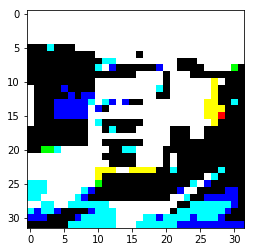

In [20]:
print(y_train[1000])
plt.imshow(x_train[1000])

In [21]:
#########
# Result
########
is_correct = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

In [22]:
# Loss 함수
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_))

#cross_entropy = -tf.reduce_sum(y_*tf.log(y))
#cross_entropy = tf.reduce_mean((y-y_)**2)
train_batch_size = 100
test_batch_size = 100
total_train_batch = int(50000/train_batch_size)
total_test_batch = int(10000/test_batch_size)

#checkpoint를 저장하는 위치
#ckpt = tf.train.get_checkpoint_state('./cnn(cifar10)')
# global_variables 함수를 통해 앞서 정의하였던 변수들을 저장하거나 불러올 변수들로 설정함.

saver = tf.train.Saver(tf.global_variables())
global_step = tf.Variable(0, trainable=False, name='global_step')

number_of_epochs = 250
#batch normalization을 제대로 하기 위해 graph에 mean average를 update하라고 말한다.
# http://ruishu.io/2016/12/27/batchnorm/ 를 참조하기 
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)


with tf.control_dependencies(update_ops):
     # Ensures that we execute the update_ops before performing the train_step
     train_step = tf.train.AdamOptimizer(0.001).minimize(cost, global_step=global_step)
    
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

#sess = tf.InteractiveSession() 
sess.run(tf.global_variables_initializer())

for epoch in range(number_of_epochs):
    total_cost = 0
    total_accuracy = 0
    #checkpoint가 있으면 restore하고 아니면 변수들을 초기화한다. 
#    if ckpt:
#        saver.restore(sess, ckpt.model_checkpoint_path)
#    else:
#     sess.run(tf.global_variables_initializer())
    start_time = time.time()
    for i in range(total_train_batch):
        
        batch = next_batch(train_batch_size, x_train, y_train_one_hot.eval())
        _, cost_val = sess.run([train_step,cost], feed_dict={x: batch[0], y_: batch[1], phase: True})
        total_cost += cost_val

    print('Epoch:', '%04d' % (epoch + 1),'Avg. cost =', '{:.3f}'.format(total_cost))
    print("--- %s seconds ---" % (time.time() - start_time))
        
    for i in range(total_test_batch):

        test_batch = next_batch(test_batch_size, x_test, y_test_one_hot.eval()) 
        acc = sess.run(accuracy, feed_dict={x: test_batch[0], y_: test_batch[1], phase: False})
        total_accuracy += acc
    
    mean_accuracy = total_accuracy/total_test_batch
    print('Accuracy:', mean_accuracy) # test batch에 대한 정확도 출력....(batch사이즈가 작아서 정확하지 않아도 됨.)
    
#변수를 checkpoint파일에 저장.    
#    saver.save(sess, './cnn(cifar10)/dnn.ckpt', global_step=global_step)


print('End of optimization!')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Epoch: 0001 Avg. cost = 831.354
--- 18.224003553390503 seconds ---
Accuracy: 0.3795999997854233
Epoch: 0002 Avg. cost = 549.396
--- 16.579060792922974 seconds ---
Accuracy: 0.5556999963521957
Epoch: 0003 Avg. cost = 449.665
--- 16.744030475616455 seconds ---
Accuracy: 0.6531000006198883
Epoch: 0004 Avg. cost = 391.021
--- 16.843279123306274 seconds ---
Accuracy: 0.7079999995231628
Epoch: 0005 Avg. cost = 350.213
--- 16.75106716156006 seconds ---
Accuracy: 0.7252000004053116
Epoch: 0006 Avg. cost = 317.275
--- 16.708984851837158 seconds ---
Accuracy: 0.7464000016450882
Epoch: 0007 Avg. cost = 290.833
--- 16.796111345291138 seconds ---
Accuracy: 0.7547000014781952
Epoch: 0008 Avg. cost = 270.735
--- 16.76414179801941 seconds ---
Accuracy: 0.768400001525879
Epoch: 0009 Avg. cost = 256.882
--- 16.6770